# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
import math
import re
import collections
import zipfile
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing

#### (1) Read file 

In [2]:
df = pd.read_csv('data/Pork Bill - LY.csv',encoding='utf-8')
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])
data = df[['text', 'pork_bill']]

In [3]:
data.head(10)

,text,pork_bill
0,軍人撫卹條例第十八條條文修正草案落實軍人及眷屬之照顧（撫卹金）,1
1,所得稅法第十七條條文修正草案學費之特別扣除額應以每人所繳之學雜費為限,1
2,所得稅法第十一條條文修正草案保險人員申報時得扣除一定比例之業務必要費用,1
3,土地稅法第二十八條之一條文修正草案土地贈與文教基金會未能免爭土地增值稅，修正之,1
4,敬老福利生活津貼暫行條例第三條條文修正草案放寬請領資格之門檻,1
5,洗錢防制法部分條文修正草案給予法官較大權限；起訴期間禁止被告的高消費行為,0
6,日據時代日本政府國庫券及債券處理條例草案就是保障日據時代持有日本債券者,0
7,大陸地區人民來臺從事觀光活動條例草案開放大陸人民觀光，振興經濟,0
8,限制欠稅人或欠稅營利事業負責人出境實施條例草案現行法令僅為行政命令位階,0
9,使用牌照稅法第七條條文修正草案民營汽車駕駛人訓練機構之教練車亦應免徵使用牌照稅,1


In [4]:
print(" Pork Legislation", data['pork_bill'].value_counts()[0],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[1])

 Pork Legislation 792 
 None-Pork Legislation 399


#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

# import spacy
# # python3 -m spacy download zh_core_web_sm
# spacy_nlp = spacy.load("zh_core_web_sm")

# data_clean = [clearPucts(text) for text in data.text]
# data_clean = [[spacy_nlp(sentence).vector for sentence in data] for data in data_clean]

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)


#### (4) Spliting Training/ Testing Set

In [8]:
data_labels = data.pork_bill.values

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (797, 123) 
Shape of X Test : (394, 123) 
Shape of Y Trian: (797,) 
Shape of Y Test : (394,)


In [10]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 797 
 Not Pork vs Pork: {0: 527, 1: 270}


In [11]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 394 
 Not Pork vs Pork: {0: 265, 1: 129}


-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [12]:
class DCNN(tf.keras.Model):
    
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="dcnn"):
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, 
                                          emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, 
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D() # no training variable so we can
                                             # use the same layer for each
                                             # pooling step
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")
    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output


In [13]:
VOCAB_SIZE = 1819 # tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.2
BATCH_SIZE = 32
NB_EPOCHS = 150

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

#### (2) Compile and Summary of the Model

In [14]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (123 , EMB_DIM)) # (train_inputs.shape[1] , EMB_DIM)
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  363800    
_________________________________________________________________
conv1d (Conv1D)              multiple                  40100     
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_2 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d (Global multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  77056     
_________________________________________________________________
dropout (Dropout)            multiple                  0      

#### (3) Check Point Path

In [15]:
checkpoint_path = "checkpoint_recode"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

Checkpoint Located!!


-------------------------

### Stage 4: Train the Model

In [16]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)

In [17]:
Dcnn.fit(train_inputs,
         train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/150
25/25 [==============================] - 2s 40ms/step - loss: 0.0022 - accuracy: 0.9987 - val_loss: 0.4611 - val_accuracy: 0.9112
Epoch 2/150
25/25 [==============================] - 1s 36ms/step - loss: 0.0019 - accuracy: 0.9987 - val_loss: 0.4628 - val_accuracy: 0.9112
Epoch 3/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0028 - accuracy: 0.9975 - val_loss: 0.4707 - val_accuracy: 0.9086
Epoch 4/150
25/25 [==============================] - 1s 35ms/step - loss: 0.0020 - accuracy: 0.9987 - val_loss: 0.4683 - val_accuracy: 0.9112
Epoch 5/150
25/25 [==============================] - 1s 34ms/step - loss: 0.0020 - accuracy: 0.9987 - val_loss: 0.4734 - val_accuracy: 0.9112
Epoch 6/150
25/25 [==============================] - 1s 36ms/step - loss: 0.0016 - accuracy: 0.9987 - val_loss: 0.4758 - val_accuracy: 0.9112


'checkpoint_recode/ckpt-11'

-------------------------

### Stage 5: Evaluation

In [18]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.002217,0.998745,0.461126,0.911168
1,0.001946,0.998745,0.462828,0.911168
2,0.002769,0.997491,0.470669,0.908629
3,0.002043,0.998745,0.468317,0.911168
4,0.001961,0.998745,0.473415,0.911168
5,0.001597,0.998745,0.475850,0.911168


##### Too much overfitting due toless validation set ⚠️⚠️⚠️⚠️

<AxesSubplot:>

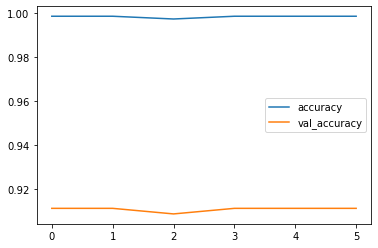

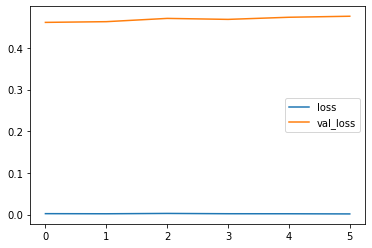

In [19]:
losses[['accuracy','val_accuracy']].plot()
losses[['loss','val_loss']].plot()

In [20]:
from sklearn.metrics import classification_report,confusion_matrix

In [21]:
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

13/13 [==============================] - 0s 5ms/step - loss: 0.4758 - accuracy: 0.9112
[0.4758498966693878, 0.9111675024032593]


In [22]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       265
           1       0.93      0.83      0.88       129

    accuracy                           0.92       394
   macro avg       0.93      0.90      0.91       394
weighted avg       0.92      0.92      0.92       394



In [23]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),257,8
Acutal: Pork (1),22,107


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 200 samples from Leislative Questions

In [24]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [25]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Sampled Legislative Questions

In [26]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).head(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
3390,林建榮,0.997636079788208,為政府應信守誠信及信賴保護原則，對公教人員一次退休金、公保養老給付優惠存款金額及18%存款利...,存款 ; 公務員退休 ; 利息,優惠存款 ; 退休金
7690,羅世雄,0.983991324901581,鑑於教育部一綱多本實施多年，衍生諸多問題，要求教育部應對一綱多本政策作通盤檢討，規劃相關配套...,教育政策 ; 國民教育,一綱多本
38,丁守中,0.983661413192749,針就日前民眾向本席陳情，政府將領取政府微薄退休金之公務機關司機、工友，列為不得請領敬老福利生...,退休金 ; 老年給付,退休金 ; 司機 ; 工友 ; 敬老福利生活津貼
4459,林重謨,0.969638943672180,謨針對台商子女與各階層子女教育資源補助分配不均，所引發之社會疑慮，特向行政院提出質詢。,教育補助,台商子女
10471,馮定國,0.960743188858032,鑒於國內經濟結構的快速調整，與人口高齡化的進展，未來中高齡失業問題必將日益嚴重，致使國人老年...,老人福利,高齡化 ; 中高齡失業
4790,楊瓊瓔,0.955101132392883,鑒於日前行政院擬於明年四月全面取消四十二萬榮民的醫療補助，且校、將級榮民的部分負擔，也將由目...,榮民醫療 ; 榮民福利,榮民醫療補助
4435,林重謨,0.941002488136292,針對彰化縣教育經費不足，急需中央補助，特向行政院提出緊急質詢。,地方財政 ; 教育經費,彰化縣 ; 教育經費
4382,林進興,0.939083576202393,鑒於今年八月，高中職及五專登記分發放榜，眾多私立高中職校嚴重招生不足，連公立的高中職校也有五...,高中 ; 學校招生,高中職 ; 五專 ; 招生不足
4457,林重謨,0.920966327190399,針對台灣農產品輸日，項目少、關稅高等問題，特向行政院提出質詢。,農產品貿易,農產品 ; 關稅高
625,吳成典,0.914839148521423,針對離島金門地區現有公車57輛，其中車齡7年以上公車達17輛之多，為維護行車安全，建請政府補...,政府補助 ; 客運業,行車安全


##### Last 10 Rows of 2000 Sampled Legislative Questions

In [27]:
pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False).tail(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
10086,陳朝龍,0.000000000234690,針對中信金控利用香港分行，發行海外債券投資股權連結商品，用以投資兆豐金控一事，金管會雖然對中...,金融政策,中信金控 ; 金控投資 ; 金控併購
1019,周守訓,0.000000000188457,針對行政院金融監督管理委員會提出「現金卡廣告最新規範」，宣布自五月一日起，現金卡應暫停在電子...,消費貸款 ; 銀行管理,現金卡廣告
5588,潘孟安,0.000000000135253,有鑒於(96)年春節假期前夕，連續發生喜洋洋及辰欣旅行社無預警倒閉事件，目前春節旅遊旺季將至...,旅遊業 ; 消費者保護,旅行社 ; 惡性倒閉
3803,林正峰,0.000000000044962,針對教育部長民意信箱網頁，竟出現內容有髒話的回應，教育部長民意信箱的設計原意很好，民眾就可直...,政府官員,教育部長 ; 髒話 ; 部長民意信箱
6602,王幸男,0.000000000030020,針對儘管台灣朝野反彈、國際社會指責，中國人大會議仍然在昨天執意通過所謂「反分裂國家法」。這個...,中國問題 ; 國家政策,反分裂國家法 ; 台灣人民 ; 主權
6104,王幸男,0.000000000029972,針對立法院日前通過決議，希望簽署加入聯合國「消除對婦女一切形式歧視公約」，但聯合國秘書長潘基...,國際組織,聯合國 ; 第二七五八號決議案 ; 台灣
5859,王世堅,0.000000000022116,針對上市上櫃公司的主要股東或經營團隊，透過個人名義，或以第三地方式進入大陸投資，應揭露財報資...,金融政策,上市 ; 上櫃 ; 股東 ; 金融監督
7560,紀國棟,0.000000000011128,鑑於監視器是維持治安不可或缺之工具，惟監視器維修經費龐大，若遇颱風豪雨嚴重損壞費用很高，多數...,電子監視,監視器.損壞維修
260,何智輝,0.000000000004389,針對近來信用卡循環利率及現金卡利率均高達18%以上，為存款利率十倍，讓發卡銀行大賺暴利，卻讓...,信用卡 ; 利率,信用卡循環利率 ; 現金卡利率
8793,賴士葆,0.000000000003444,查行政院金融監督管理委員會日前提出的卡債協商機制辦法中，僅將債權屬於銀行（八大銀行或其他相關...,金融政策 ; 債務,卡債協商機制 ; 卡奴 ; 暴力討債


#### (2) Export an End-to-end Model


In [28]:
from tensorflow.keras.models import load_model

In [29]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [30]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')